# ОПИСАНИЕ ПРОЕКТА

**ЗАДАЧА**: Построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

**ЭТАПЫ РАБОТЫ**:

1. Первичная визуализация - выводы о качестве данных, распределение целевой переменной;
2. Построение наивной модели + метрики;
3. EDA: визуализация, выбросы, пропуски, корреляционный анализ, генерация признаков; 
4. Оценка важности;
5. Построение модели логистической регрессии;
6. Подбор гиперпараметров;
7. Эксперименты с другими моделями, определение лучшей;
8. Финальная модель, submission. 

**ОПИСАНИЯ ПОЛЕЙ**:

* **client_id** - идентификатор клиента
* **education** - уровень образования
* **sex** - пол заемщика
* **age** - возраст заемщика
* **car** - флаг наличия автомобиля
* **car_type** - флаг автомобиля иномарки
* **decline_app_cnt** - количество отказанных прошлых заявок
* **good_work** - флаг наличия “хорошей” работы
* **bki_request_cnt** - количество запросов клиента в БКИ о своей кредитной истории
* **home_address** - категоризатор домашнего адреса
* **work_address** - категоризатор рабочего адреса
* **income** - доход заемщика
* **foreign_passport** - наличие загранпаспорта
* **sna** - связь заемщика с клиентами банка
* **first_time** - давность наличия информации о заемщике
* **score_bki** - скоринговый балл по данным из БКИ
* **region_rating** - рейтинг региона
* **app_date** - дата подачи заявки
* **default** - флаг дефолта по кредиту

# Используемые библиотеки

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# Вспомогательные функции

In [2]:
def visualise_metrics(model, X, y):
    '''Функция для разделения выборки на train и valid'''
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, random_state=RANDOM_SEED, test_size=0.2)

    # Обучение модели на тренировочных данных и предсказание на валидационных
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)

    # Вывод типа модели:
    print()
    print('Model Type: ' + str(model))
    print()

    # Вывод confusion matrix:
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True\nPositive', 'False\nPositive',
                   'False\nNegative', 'True\nNegative']
    group_counts = ['{0:0.0f}'.format(
        value) for value in confusion_matrix(y_valid, y_pred).flatten()]
    labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_valid, y_pred),
                     annot=labels, fmt='', cmap='Reds')
    ax.set(xlabel='predicted', ylabel='real', title='Confusion Matrix')
    plt.show()
    print()

    # Вывод значений метрик:
    print('accuracy_score:\t\t {:.3}'.format(accuracy_score(y_valid, y_pred)))
    print('f1_score:\t\t {:.3}'.format(f1_score(y_valid, y_pred)))
    print('precision_score:\t {:.3}'.format(precision_score(y_valid, y_pred)))
    print('recall_score:\t\t {:.3}'.format(recall_score(y_valid, y_pred)))
    print('roc_auc_score:\t\t {:.3}'.format(roc_auc_score(y_valid, probs)))
    print()
    

def show_outliers(data, column): 
    '''Функция для рассчета выбросов методом IQR'''
    q25, q75 = data[column].quantile([0.25, 0.75])
    IQR = q75 - q25
    low_limit = q25 - 1.5 * IQR
    up_limit = q75 + 1.5 * IQR
    print("IQR range [{}, {}]".format(low_limit, up_limit),
                       "\nMin. value: {} \nMax. value: {}".
    format(data[column].min(), data[column].max()))
    print("Number below the lower limit: {}, number above the upper limit: {}".
    format(data[data[column] < low_limit][column].count(),
           data[data[column] > up_limit][column].count()))

# Оценка датасета

In [3]:
RANDOM_SEED=42

In [4]:
data = pd.read_csv("/kaggle/input/sf-dst-scoring/train.csv")
test_data = pd.read_csv("/kaggle/input/sf-dst-scoring/test.csv")
sample = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [5]:
# Для корректной обработки объединяем данные
data['sample'] = 1  # Помечаем тренировочные данные
test_data['sample'] = 0  # Помечаем тестовые данные
test_data['default'] = -1

df = test_data.append(data, sort=False).reset_index(drop=True)

In [6]:
print(data.info())
print('data size: ', data.shape)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1


In [7]:
print(test_data.info())
print('test_data size: ', test_data.shape)
test_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,-1
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,-1
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,-1
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,-1
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,-1


In [8]:
print(sample.info())
print(sample.shape)
sample.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
None
(24354, 2)


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


В датасете всего **18 переменных** (помимо переменной **sample**, разделяющей тренировочную и тестовую выборку) и целевая переменная **default**.

# 1. Первичная визуализация

In [9]:
# pp.ProfileReport(df)

Имеются признаки с различными типами данных - **числовые**, **категориальные** и **бинарные**.

Иcходя из контекста и описания, переменные **car** и **car_type** дублируют информацию друг друга. Возможно, эти две переменные будут иметь значительную коллинеарность (проверим позже).

**Бинарные** признаки будут обработаны с помощью **LabelEncoder'a**, а из **категориальных** признаков будут созданы **dummy переменные**.

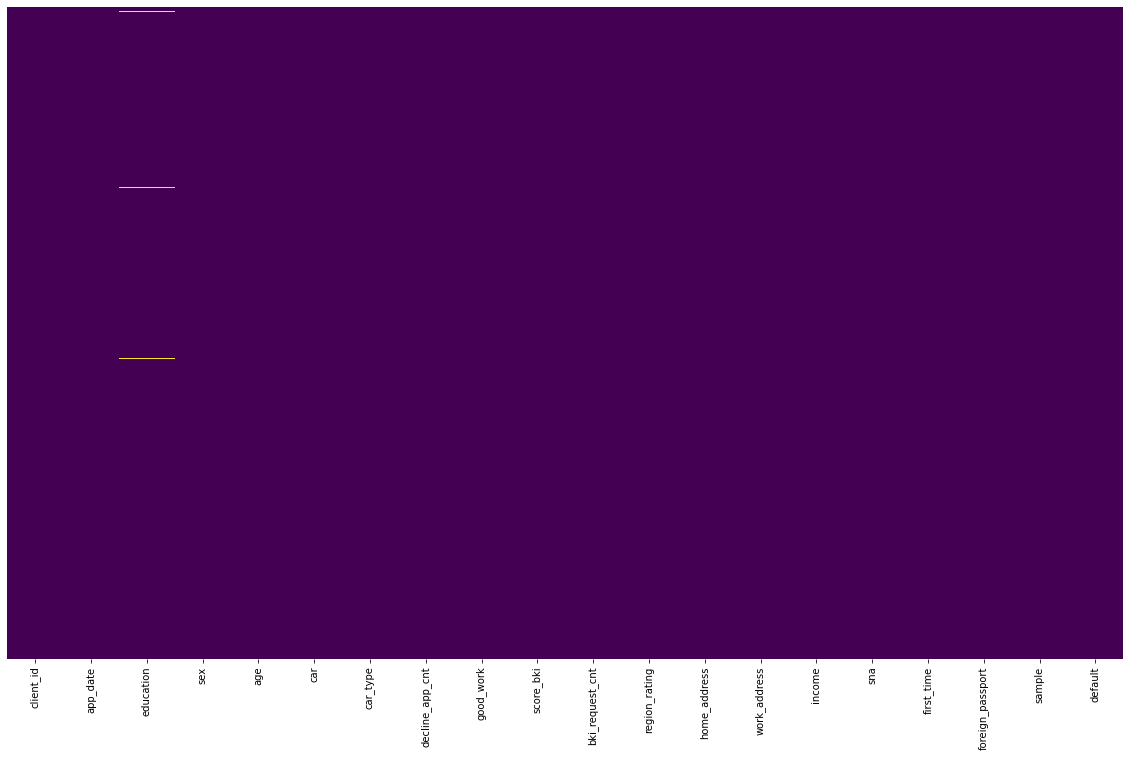

In [10]:
fig, ax = plt.subplots(figsize=(20, 12))
sns_heatmap = sns.heatmap(
    df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Есть пропущенные значения в столбце **education**. Их количество несущественно.

Посмотрим на распределение признака **default**:

<AxesSubplot:>

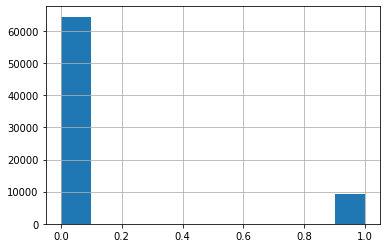

In [11]:
data.default.hist()

Недефолтных клиентов у банка значительно больше, чем дефолтных. Данные несбалансированны.

Сгруппируем признаки в три категории по типу их обработки (**категориальные**, **бинарные** и **числовые**):

In [12]:
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'app_date']

# Числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki', 'region_rating', 'first_time']

Смотрим распределение **числовых признаков**:

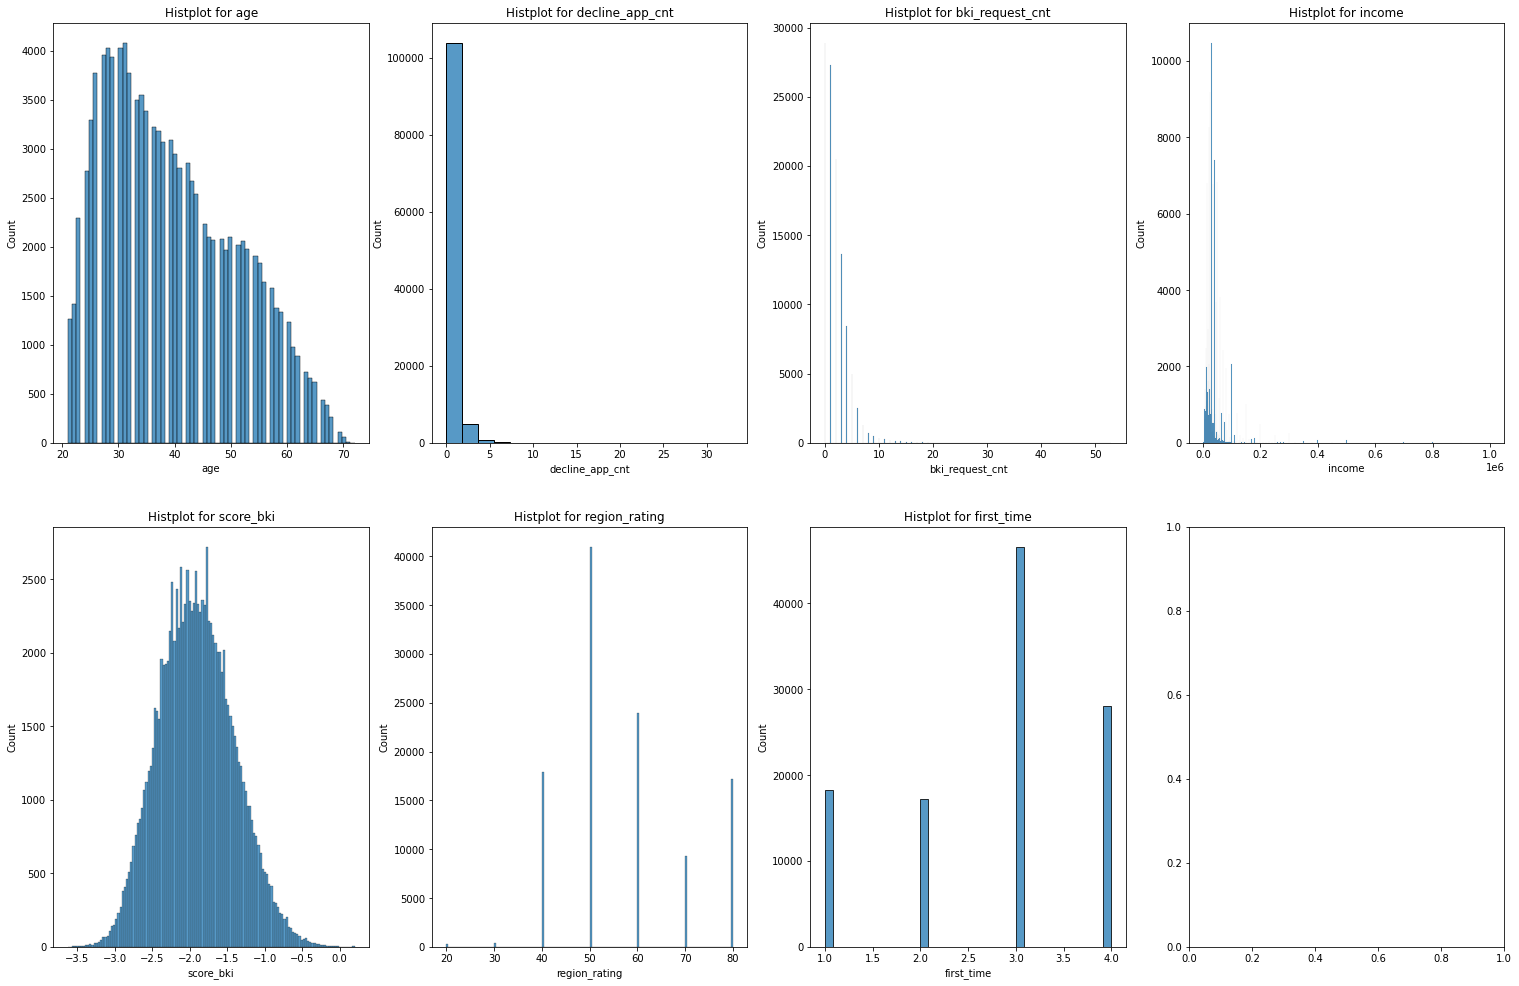

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(26,17))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes.flat[i]).set(title='Histplot for ' + col)

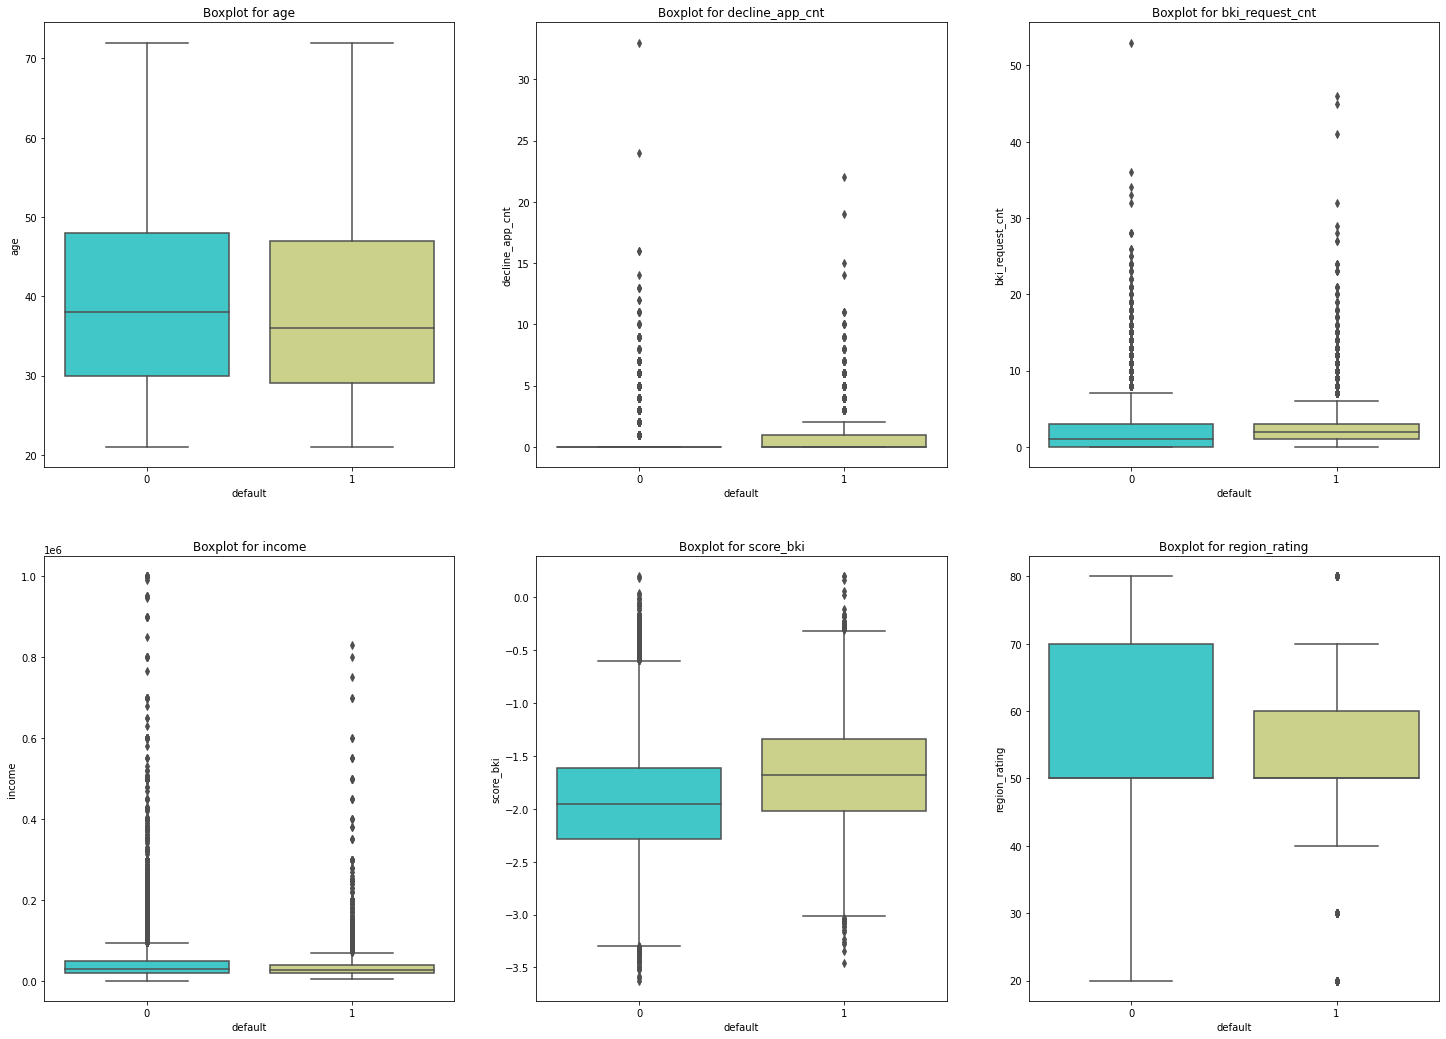

In [14]:
# Распределение дефолтных клиентов относительно числовых признаков
fig, axes = plt.subplots(2, 3, figsize=(25,18))
for i, col in enumerate(num_cols[:-1]):
    sns.boxplot(y = data[col], x = 'default', data=data, ax=axes.flat[i],
                      palette='rainbow').set(title='Boxplot for ' + col)

* Видим, что распределения всех чиловых признаков, кроме **score_bki**, имеют тяжелый правый хвост.
* Дефолтные клиенты в среднем младше, имеют большее количество отклоненных заявок и больше запросов в БКИ. А также в среднем имеют более низкий доход.
* В **region_rating** хоть данные и предоставлены в числовом виде, имеется некоторая тенденция к категориальности, где значения распределены от 20 до 80 с шагом в 10.

Оценим корреляцию числовых признаков:

Text(0.5, 1.0, 'График корреляций числовых переменных')

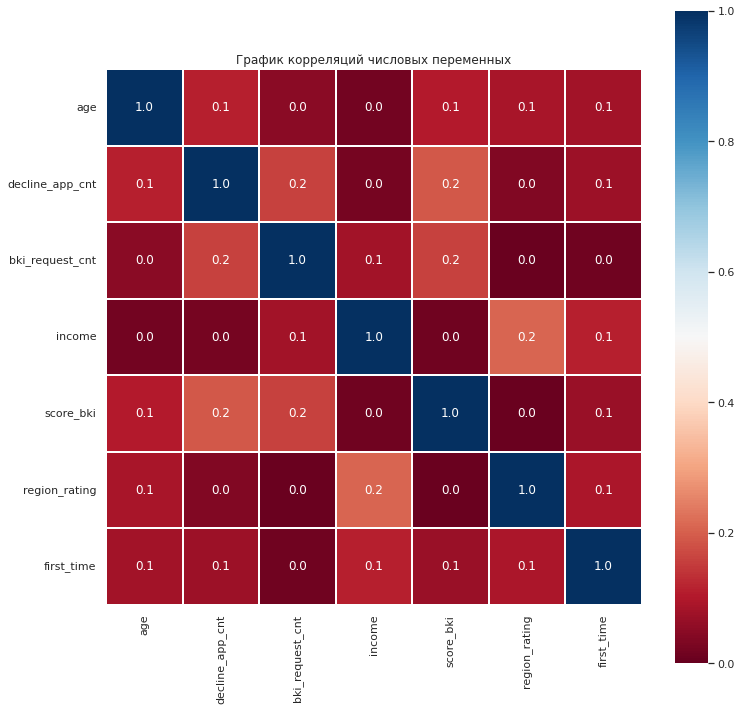

In [15]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
                             annot=True, fmt=".1f", linewidths=0.1,
    cmap="RdBu").set_title('График корреляций числовых переменных')

<AxesSubplot:>

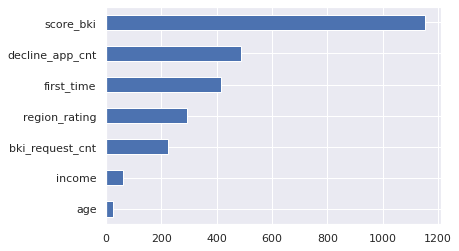

In [16]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Так как **категориальные** признаки требуют обработки, рассмотрим их подробнее позже.

# Построение наивной модели

Займемся преобразованием **бинарных признаков**:

In [17]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

Удалим **education** из-за наличия пропусков. Также удалим **app_date** и **client_id**:

In [18]:
df_naiv = df.drop(['client_id', 'education', 'app_date'], axis=1)

In [19]:
train_processed = df_naiv.query('sample == 1').drop(['sample'], axis=1)
test_processed = df_naiv.query('sample == 0').drop(['sample'], axis=1)

In [20]:
# Удалим для X целевую переменную
X = train_processed.drop(columns=['default'])
y = train_processed['default']


Model Type: LogisticRegression(max_iter=1000, random_state=42)



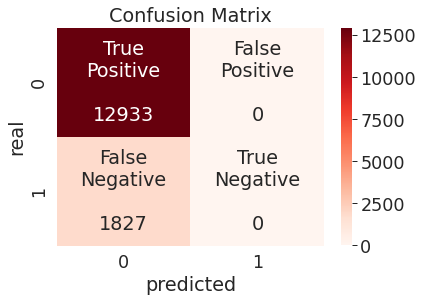


accuracy_score:		 0.876
f1_score:		 0.0
precision_score:	 0.0
recall_score:		 0.0
roc_auc_score:		 0.584



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
visualise_metrics(lr, X, y)

Наивная модель выдает кредит абсолютно всем и предсказывает отсутствие дефолтных клиентов. Идеально, но несопоставимо с реальностью.

# EDA: визуализация, выбросы, пропуски, корреляционный анализ, генерация признаков

# Выбросы

In [22]:
# Смотрим на выбросы числовых признаков
for col in num_cols:
    print(col)
    show_outliers(df, col)
    print("\n")

age
IQR range [3.0, 75.0] 
Min. value: 21 
Max. value: 72
Number below the lower limit: 0, number above the upper limit: 0


decline_app_cnt
IQR range [0.0, 0.0] 
Min. value: 0 
Max. value: 33
Number below the lower limit: 0, number above the upper limit: 18677


bki_request_cnt
IQR range [-4.5, 7.5] 
Min. value: 0 
Max. value: 53
Number below the lower limit: 0, number above the upper limit: 2636


income
IQR range [-22000.0, 90000.0] 
Min. value: 1000 
Max. value: 1000000
Number below the lower limit: 0, number above the upper limit: 7000


score_bki
IQR range [-3.299251946250001, -0.5290698762499992] 
Min. value: -3.62458632 
Max. value: 0.19977285
Number below the lower limit: 82, number above the upper limit: 436


region_rating
IQR range [35.0, 75.0] 
Min. value: 20 
Max. value: 80
Number below the lower limit: 747, number above the upper limit: 17170


first_time
IQR range [-1.0, 7.0] 
Min. value: 1 
Max. value: 4
Number below the lower limit: 0, number above the upper limit: 0


В переменной **decline_app_cnt** 83% значений нулевые. Убирать все значения выше 0 - абсолютно лишено смысла. 

Посмотрим на процентное распределение уникальных значений:

In [23]:
df['decline_app_cnt'].value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
21    0.000009
30    0.000009
20    0.000009
19    0.000009
22    0.000009
33    0.000009
15    0.000009
24    0.000009
Name: decline_app_cnt, dtype: float64

Значения выше 4 встречаются реже, чем у 0.5% данных. Заменяем все значения выше 4 на 4 и использовать как категориальный признак при построении модели.

In [24]:
df.loc[df['decline_app_cnt'] > 4, 'decline_app_cnt'] = 4

In [25]:
# Посмотрим на результат
df['decline_app_cnt'].value_counts(normalize=True)

0    0.830437
1    0.113484
2    0.032883
3    0.012392
4    0.010804
Name: decline_app_cnt, dtype: float64

Похожая ситуация с переменной **bki_request_cnt**. Проделаем то же самое.

In [26]:
df['bki_request_cnt'].value_counts(normalize=True)

0     0.262447
1     0.247803
2     0.185941
3     0.124106
4     0.076316
5     0.045030
6     0.022697
7     0.011730
8     0.006673
9     0.004167
10    0.003178
11    0.002524
12    0.001970
13    0.001371
14    0.000999
15    0.000735
16    0.000527
17    0.000300
18    0.000291
19    0.000272
21    0.000172
20    0.000127
23    0.000109
24    0.000109
22    0.000073
28    0.000045
25    0.000045
27    0.000045
26    0.000036
32    0.000036
29    0.000027
33    0.000018
40    0.000018
47    0.000009
34    0.000009
36    0.000009
53    0.000009
45    0.000009
41    0.000009
46    0.000009
Name: bki_request_cnt, dtype: float64

In [27]:
# Определим порог значением 5 
df.loc[df['bki_request_cnt'] > 5, 'bki_request_cnt'] = 5

In [28]:
df['income'].value_counts(normalize=True)

30000     0.094754
25000     0.082525
20000     0.074209
40000     0.067028
50000     0.061209
            ...   
49700     0.000009
14271     0.000009
38100     0.000009
426000    0.000009
100600    0.000009
Name: income, Length: 1207, dtype: float64

В случае **income**, порог в 90000 так же не особенно реалистичен. Исходя из графиков распределения, условная граница, после которой почти нету значений - 0.4. Выберем верхнюю границу в 500к и заменим этим значением все, что выше.

In [29]:
# Определим порог значением 500000
df.loc[df['income'] > 500000, 'income'] = 500000

Установим нижнюю границу **score_bki** согласно IQR range. Для верхней границы используем значение 0.

In [30]:
df.loc[df['score_bki'] < -3.299, 'score_bki'] = -3.299
df.loc[df['score_bki'] > 0, 'score_bki'] = 0

* Признак **education**

<AxesSubplot:>

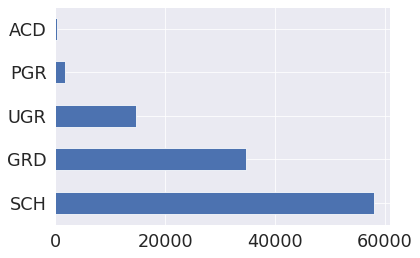

In [31]:
df.education.value_counts().plot.barh()

Заполним пропуски самым распространенным значением - "**SCH**":

In [32]:
df.education = df.education.fillna(df.education.mode()[0])
df.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

Закодируем  признак **education**:

In [33]:
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,1,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,-1
1,17527,24JAN2014,3,0,39,0,0,4,0,-1.504999,2,50,1,2,5000,4,3,0,0,-1
2,75683,23MAR2014,4,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,-1
3,26883,03FEB2014,3,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,-1
4,28862,04FEB2014,1,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,-1


* Распределения всех чиловых признаков, кроме **score_bki**, имеют тяжелый правый хвост. Прологарифмируем их позже, чтобы уйти от этой проблемы. **score_bki** исключим из логарифмирования, так как он может принимать отрицательные значения.

In [34]:
for i in num_cols:
    if i != 'score_bki':
        df[i] = np.log(1 + df[i])

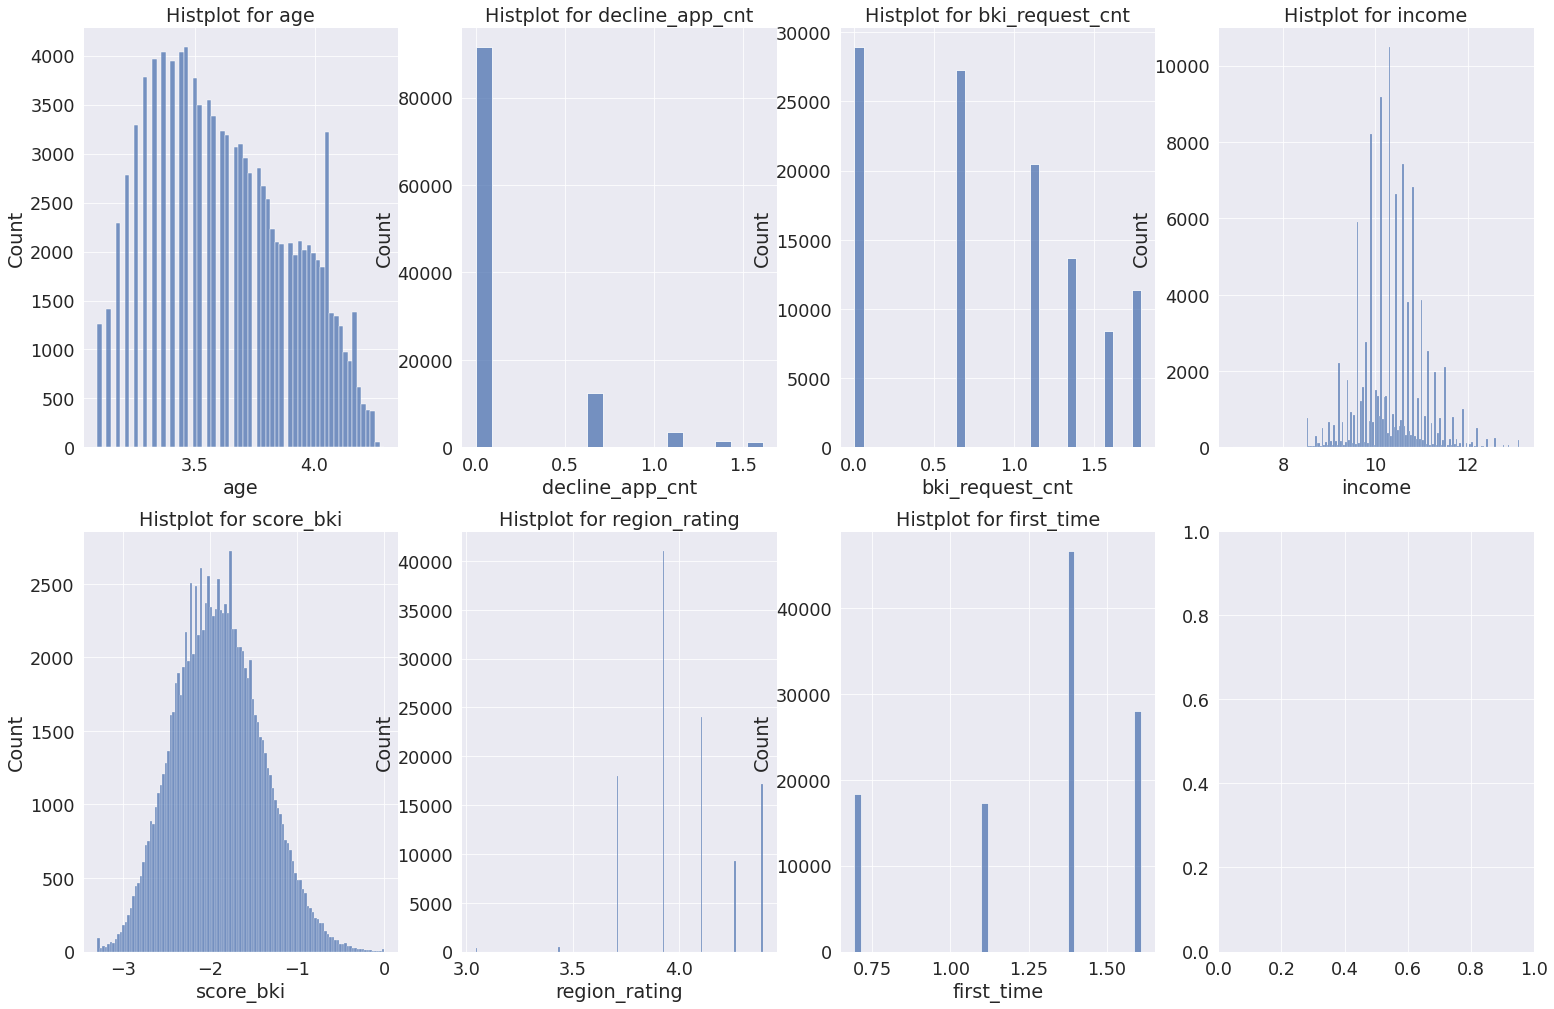

In [35]:
fig, axes = plt.subplots(2, 4, figsize=(26,17))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes.flat[i]).set(title='Histplot for ' + col)

Сработало только с признаком **income**.

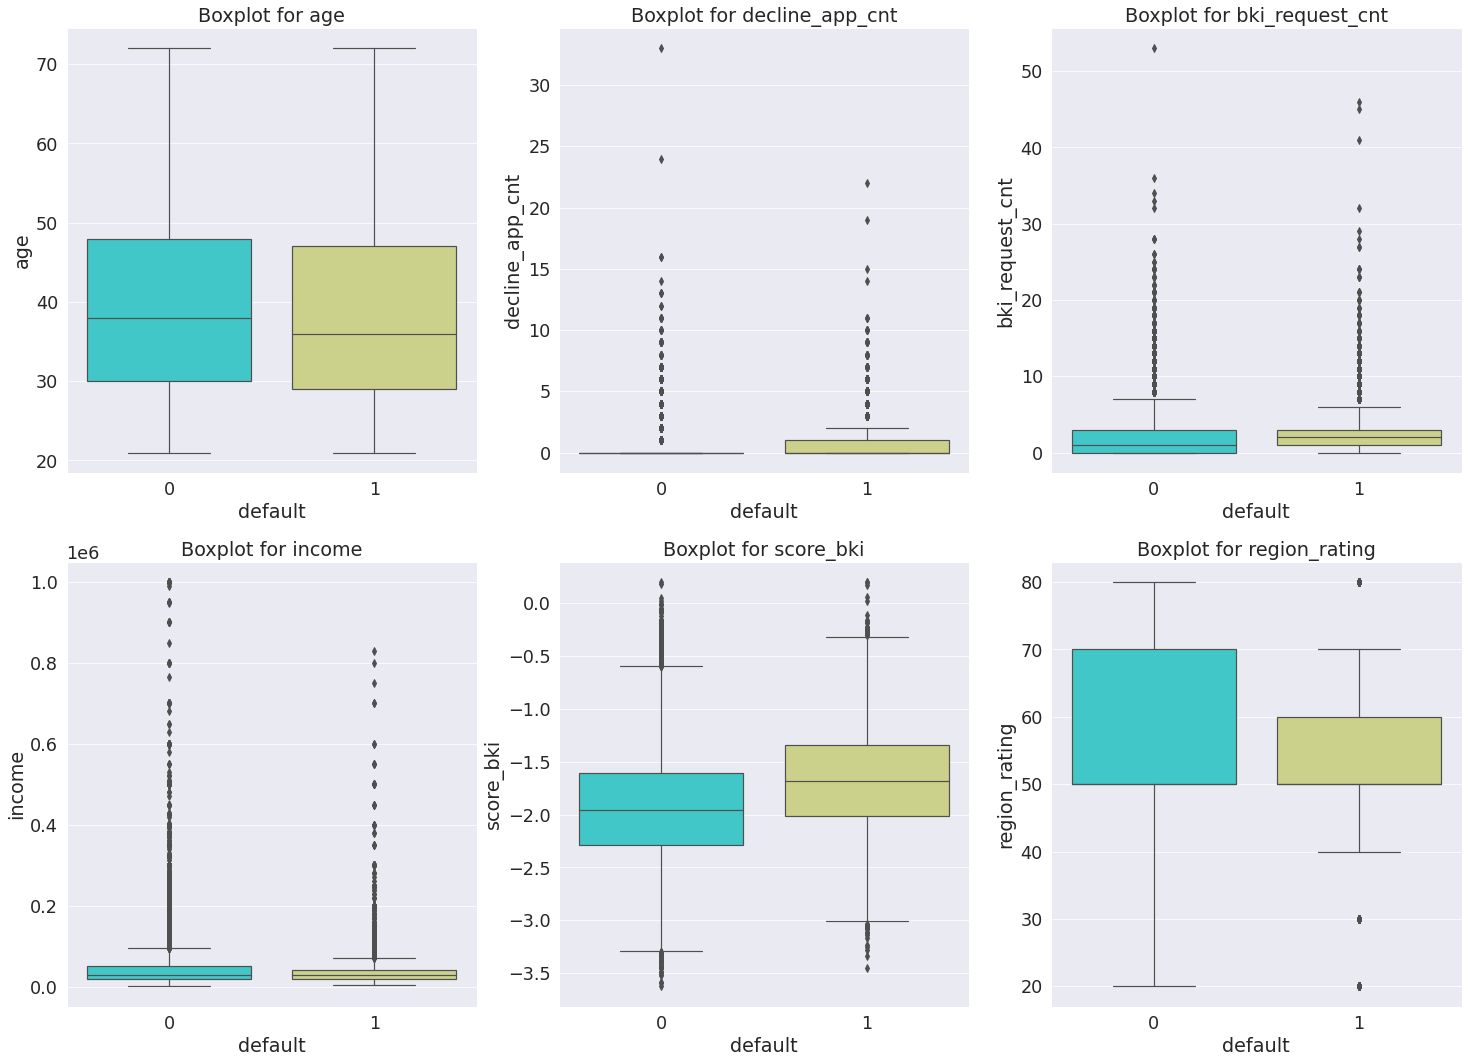

In [36]:
# Распределение дефолтных клиентов относительно числовых признаков
fig, axes = plt.subplots(2, 3, figsize=(25,18))
for i, col in enumerate(num_cols[:-1]):
    sns.boxplot(y = data[col], x = 'default', data=data, ax=axes.flat[i],
                      palette='rainbow').set(title='Boxplot for ' + col)

На боксплотах видно большое количество выбросов в **score_bki**, **income**, **bki_request_cnt** и **decline_app_cnt**.

* Признак **app_date**

In [37]:
# Преобразуем в формат даты
df['app_date'] = pd.to_datetime(df['app_date'])

# Вычислим количество дней с самой давней записи в датасете 
df['app_days'] = df['app_date'].apply(lambda x: x - df['app_date'].min())
df['app_days'] = df['app_days'].dt.days
df.drop('app_date', axis=1, inplace=True)

# Обновим список с числовыми признаками
cat_cols = list(set(cat_cols) - set(['app_date']))
num_cols = num_cols + ['app_days']

# Оценка важности

Оценим корреляцию и значимость **числовых признаков**:

Text(0.5, 1.0, 'График корреляций числовых переменных')

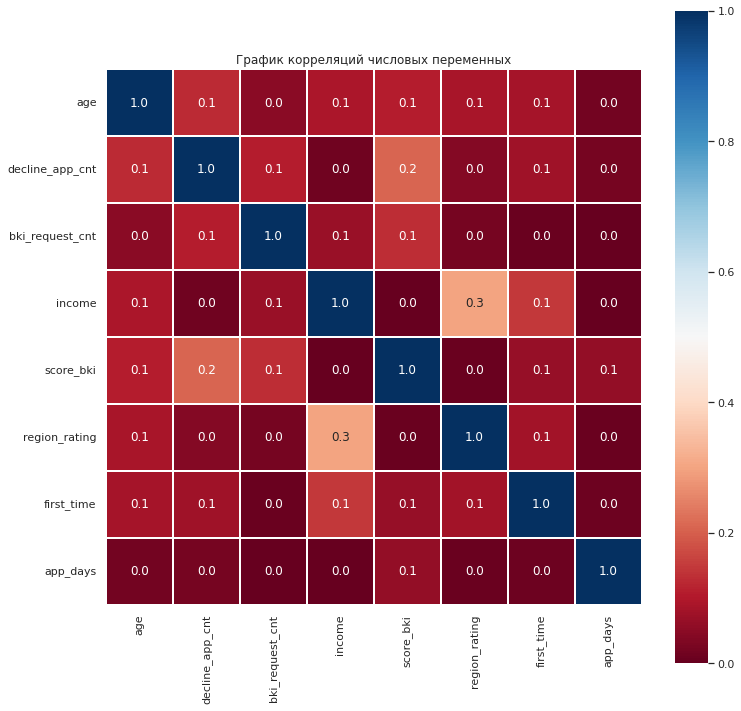

In [38]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, square=True,
                             annot=True, fmt=".1f", linewidths=0.1,
    cmap="RdBu").set_title('График корреляций числовых переменных')

<AxesSubplot:>

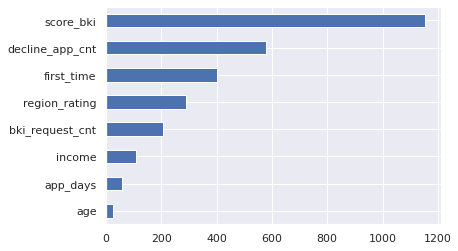

In [39]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Как мы видим, взаимосвязь пар числовых признаков по Пирсону слабая, что прекрасно для нашей модели! 
**score_bki** - наиболее значимый числовой признак, **age** - наименее значимый.

Оценим корреляцию и значимость **категориальных и бинарных признаков**:

Text(0.5, 1.0, 'Корреляция категориальных и бинарных переменных')

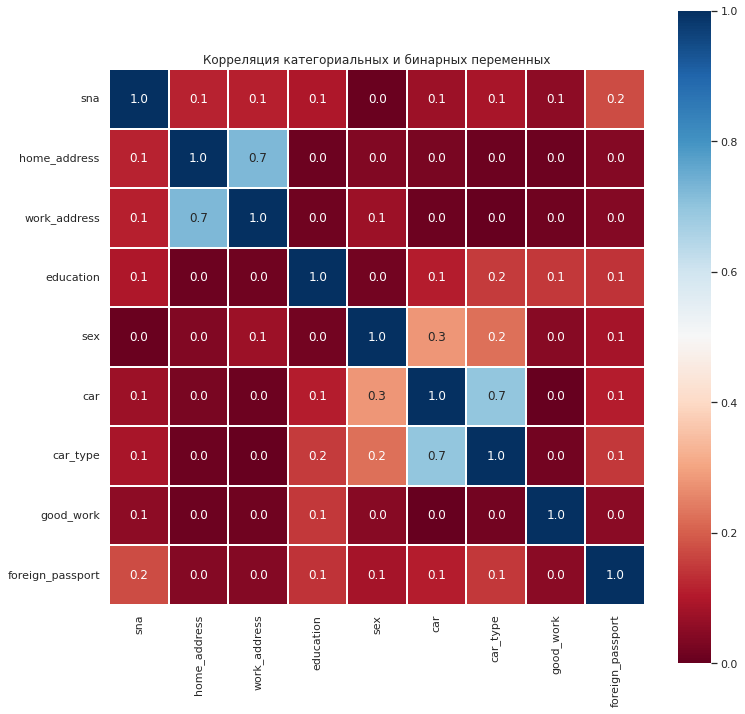

In [40]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[cat_cols + bin_cols].corr().abs(), vmin=0, vmax=1, square=True,
                             annot=True, fmt=".1f", linewidths=0.1,
     cmap="RdBu").set_title('Корреляция категориальных и бинарных переменных')

Наблюдается высокая корреляция между признаками **home_addres/work_address**, **car/car_type**. Посмотрим на значимость признаков и решим, какие отбросить, а какие оставить.

<AxesSubplot:>

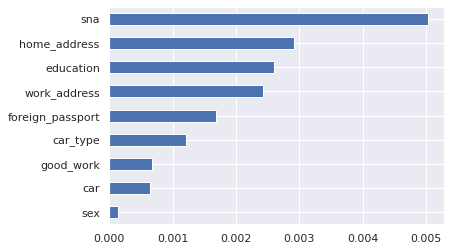

In [41]:
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                           discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Согласно значимости оставляем - **home_address** и **car_type**, удаляем - **work_address** и **car**. Также удаляем столбец **client_id**.

In [42]:
df = df.drop(df[['work_address', 'car_type', 'client_id']], axis=1)
cat_cols = list(set(cat_cols) - set(['work_address']))
bin_cols = list(set(bin_cols) - set(['car_type']))

Перед обучением регрессии стандартизируем **числовые признаки**, а для **категориальных переменных** используем dummy-кодирование:

In [43]:
X_num = StandardScaler().fit_transform(df[num_cols].values)
df[num_cols] = X_num

In [44]:
df = pd.get_dummies(df, columns=cat_cols)
df.head()

,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,first_time,...,sna_3,sna_4,home_address_1,home_address_2,home_address_3,education_0,education_1,education_2,education_3,education_4
0,1,-0.888776,1,-0.424641,0,-0.736110,0.861610,-0.439531,0.682754,1.061008,...,0,0,1,0,0,0,1,0,0,0
1,0,0.120447,0,4.151291,0,0.800354,0.394050,-0.439531,-2.630752,0.336016,...,0,1,1,0,0,0,0,0,1,0
2,1,0.972731,1,-0.424641,0,0.427019,-0.264939,-0.439531,-0.052381,0.336016,...,0,0,1,0,0,0,0,0,0,1
3,1,1.362924,0,-0.424641,0,-0.941067,-0.264939,-1.408242,-0.869759,0.336016,...,0,0,1,0,0,0,0,0,1,0
4,0,0.031629,0,-0.424641,0,-1.168105,-1.391487,1.613807,1.942669,0.336016,...,0,0,0,1,0,0,1,0,0,0


# Построение модели логистической регрессии

In [45]:
# Обновляем списки переменных
num_cols = ['age', 'score_bki', 'region_rating', 'first_time', 'app_days']
cat_cols = ['sna', 'home_address', 'education',
            'decline_app_cnt', 'bki_request_cnt', 'income']
bin_cols = ['foreign_passport', 'sex', 'good_work', 'car']


Model Type: LogisticRegression(max_iter=1000, random_state=42)



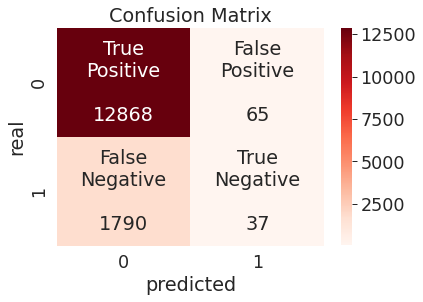


accuracy_score:		 0.874
f1_score:		 0.0384
precision_score:	 0.363
recall_score:		 0.0203
roc_auc_score:		 0.741



In [46]:
train_processed = df.query('sample == 1').drop(['sample'], axis=1)
test_processed = df.query('sample == 0').drop(['sample'], axis=1)

# Удалим для X целевую переменную 
X = train_processed.drop(columns=['default'])
y = train_processed['default']

lr = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
visualise_metrics(lr, X, y)

Предсказания модели улучшились, но всё еще неприменимы в реальной жизни. Улучшаем!

# Эксперименты


Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)



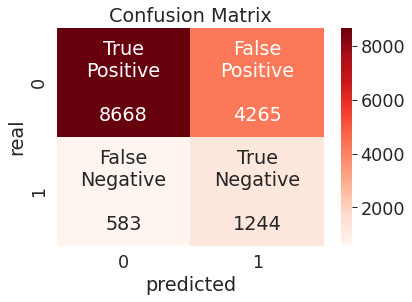


accuracy_score:		 0.672
f1_score:		 0.339
precision_score:	 0.226
recall_score:		 0.681
roc_auc_score:		 0.741



In [47]:
lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)

В сбалансированной модели резко уменьшается количество ошибок первого рода, но появляется значительное количество ошибок второго рода.

# Подбор гиперпараметров

In [48]:
# Создадим набор гиперпараметров
hyperparameters = {'C': np.logspace(-4, 4, 20)}

X = train_processed.drop(columns=['default'])
y = train_processed['default']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, random_state=RANDOM_SEED, test_size=0.2)

model = LogisticRegression(random_state=RANDOM_SEED,
                           class_weight='balanced', max_iter=1000)

# Создадим сетку поиска с использованием 5-кратной перекрёстной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0, scoring='roc_auc')

best_model = clf.fit(X_train, y_train)

# Вывод лучшего параметра С
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее C: 0.012742749857031334



Model Type: LogisticRegression(C=0.012742749857031334, class_weight='balanced',
                   max_iter=1000, random_state=42)



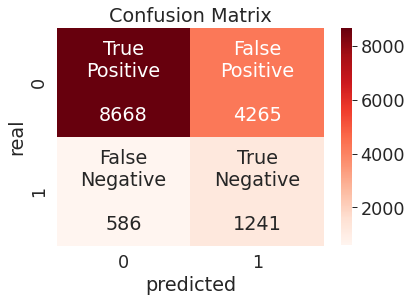


accuracy_score:		 0.671
f1_score:		 0.338
precision_score:	 0.225
recall_score:		 0.679
roc_auc_score:		 0.741



In [49]:
lr_best = LogisticRegression(random_state=RANDOM_SEED,
    class_weight='balanced', max_iter=1000, C=0.012742749857031334)
visualise_metrics(lr_best, X, y)

Попробуем применить **undersampling**:

Оставим случайным образом в тренировочных данных столько строк с нулевым дефолтом, сколько всего есть данных меньшего класса


Model Type: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)



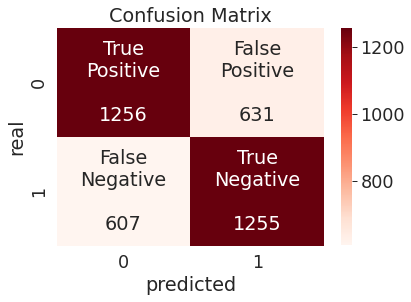


accuracy_score:		 0.67
f1_score:		 0.67
precision_score:	 0.665
recall_score:		 0.674
roc_auc_score:		 0.733



In [50]:
train_unders = pd.concat(
 [train_processed[train_processed['default'] == 0].sample(len(
 train_processed[train_processed['default'] == 1]), random_state=RANDOM_SEED),
                            train_processed[train_processed['default'] == 1]])

X = train_unders.drop(columns=['default'])
y = train_unders['default']

lr_balanced = LogisticRegression(
    class_weight='balanced', max_iter=1000, random_state=RANDOM_SEED)
visualise_metrics(lr_balanced, X, y)

Применение **undersampling** позволило значительно улучшить предсказания модели. Теперь верные предсказания по дефолтным и недефолтным клиентам превосходят ошибочные. Но показатель ROC AUC стал меньше.

# Выводы

* После обработки данных (**EDA**) построили базовую модель логистической регрессии, которая показала **ROC AUC** > 0.74, а также **accuracy** 0.874, **precision** 0.363, **recall** 0.020 и **f1_score** 0.0384
* При подборе гиперпараметра с использованием **GridSearchCV** и **логарифмсеткой** (-4,4) получили, что при значении **C** = 0.01274 модель показывает практически тот же результат. **ROC AUC** не изменился, **f1** примерно такой же 0.338.
* Также, для сравнения, построили модель логистической регрессии с одинаковым количеством классов целевой переменной. **f1** стал еще лучше 0,67 за счет изменения **recall_score**, но **ROC AUC** стал хуже 0,733. Поэтому в итоге взяли базовую модель с гиперпараметром  **C** = 0.01274.

# Финальная модель и submission

In [51]:
X_test = test_processed.drop(columns=['default'])
y_pred = lr_best.predict_proba(X_test)
results_df = pd.DataFrame(
    data={'client_id': test_data['client_id'], 'default': y_pred[:, 1]})
results_df.to_csv('submission.csv', index=False)
results_df

,client_id,default
0,74835,0.236247
1,17527,0.787845
2,75683,0.312479
3,26883,0.406280
4,28862,0.147168
...,...,...
36344,83775,0.785102
36345,106254,0.116628
36346,81852,0.753387
36347,1971,0.686934
